## Fangi Image Classification

In [42]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import glob
import cv2
import sns
from sklearn.model_selection import train_test_split

import tensorflow as tf
#from tensorflow import keras
import keras
print("Tensorflow Version:", tf.__version__)
print("Keras Version:", keras.__version__)

Tensorflow Version: 2.14.0
Keras Version: 2.14.0


### Organizing the Data as a csv-file

In [91]:
# Load data from the directory using Pandas
image_data = 'Defungi'

files = [i for i in glob.glob(image_data + "//*//*")]
np.random.shuffle(files)

# Taking the 2 symbols between the string 'Defungi\' and the file-name
labels = [os.path.dirname(i).split("/")[-1][-2:] for i in files]
data = zip(files, labels)
dataframe = pd.DataFrame(data, columns = ["Image", "Label"])
dataframe.to_csv(image_data + '\Defungi.csv')
dataframe

,Image,Label
0,Defungi\H2\H2_61h_9.jpg,H2
1,Defungi\H1\H1_11a_12.jpg,H1
2,Defungi\H3\H3_10a_6.jpg,H3
3,Defungi\H2\H2_60a_22.jpg,H2
4,Defungi\H3\H3_2a_1.jpg,H3
...,...,...
9040,Defungi\H2\H2_45b_6.jpg,H2
9041,Defungi\H6\H6_1b_6.jpg,H6
9042,Defungi\H1\H1_17a_5.jpg,H1
9043,Defungi\H1\H1_105d_3.jpg,H1


### Exploring the Data

In [92]:
# Load training and testing data from the xray_data dataset using Pandas
Defungi_data = pd.read_csv('Defungi/Defungi.csv')
Defungi_data.info()
print(Defungi_data.head(4))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9045 entries, 0 to 9044
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  9045 non-null   int64 
 1   Image       9045 non-null   object
 2   Label       9045 non-null   object
dtypes: int64(1), object(2)
memory usage: 212.1+ KB
   Unnamed: 0                     Image Label
0           0   Defungi\H2\H2_61h_9.jpg    H2
1           1  Defungi\H1\H1_11a_12.jpg    H1
2           2   Defungi\H3\H3_10a_6.jpg    H3
3           3  Defungi\H2\H2_60a_22.jpg    H2


In [93]:
Defungi_data.describe()

,Unnamed: 0
count,9045.000000
mean,4522.000000
std,2611.210926
min,0.000000
25%,2261.000000
50%,4522.000000
75%,6783.000000
max,9044.000000


### Uploading the Images from the Directory

In [94]:
import pathlib

data_dir = pathlib.Path('Defungi')

batch_size = 30
img_height = 224
img_width = 224

data = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels = 'inferred',
    label_mode = 'categorical',
    color_mode = 'rgb',
    image_size = (img_height, img_width),
    batch_size = batch_size,
    seed = 42,
    validation_split = None)


Found 9045 files belonging to 5 classes.


### Displaying the Images

30


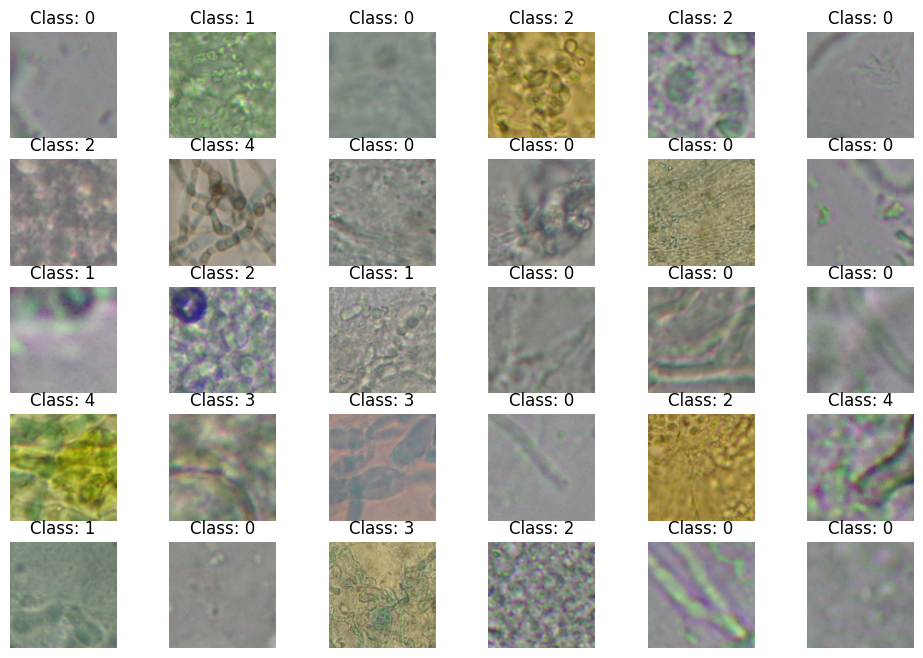

In [115]:
# Display the images

data_iterator = data.as_numpy_iterator()
images, labels = data_iterator.next()
print(len(images))
plt.figure(figsize = (12, 8))
for i in range(len(images)):
    plt.subplot(5, 6, i + 1)
#    plt.imshow(images[i]/256)
    plt.imshow(images[i].astype("uint8"))
    plt.title(f'Class: {np.argmax(labels[i])}') 
    plt.axis('off')

plt.show()

### Checking is the Number of Data in Each Class

Label
H1    4404
H2    2265
H3     819
H5     818
H6     739
Name: count, dtype: int64


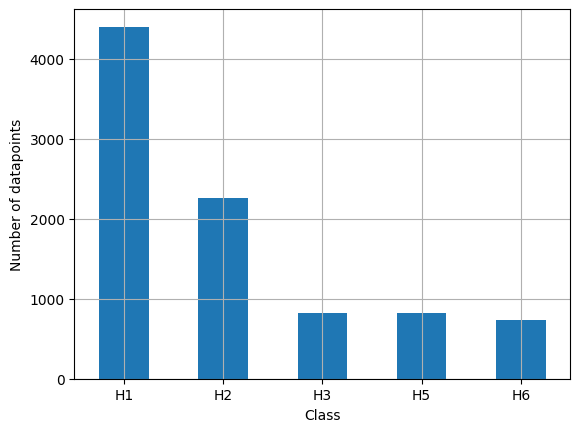

In [106]:
Cat = Defungi_data["Label"].value_counts()
print(Cat)
Defungi_data["Label"].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel("Class")
plt.ylabel("Number of datapoints")
plt.show()